In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

import torch # import pytorch
import torch.nn as nn # pytorch's neural networks module

import torch.nn.functional as F # functional module.

In [3]:
import numpy as np
#change path to the path in your drive

#Shrey's file paths

# X_test = np.load("/content/drive/MyDrive/c147finalproject/X_test.npy") 
# y_test = np.load("/content/drive/MyDrive/c147finalproject/y_test.npy")
# person_train_valid = np.load("/content/drive/MyDrive/c147finalproject/person_train_valid.npy")
# X_train_valid = np.load("/content/drive/MyDrive/c147finalproject/X_train_valid.npy")
# y_train_valid = np.load("/content/drive/MyDrive/c147finalproject/y_train_valid.npy")
# person_test = np.load("/content/drive/MyDrive/c147finalproject/person_test.npy")
#Arvind's file paths

#Richard's file paths
X_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_test.npy") 
y_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_test.npy")

In [4]:
print('Training/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Training/Valid target shape: {}'.format(y_train_valid.shape))
print('Test target shape: {}'.format(y_test.shape))
print('Person train/valid shape: {}'.format(person_train_valid.shape))
print('Person test shape: {}'.format(person_test.shape))

'''
2115 training samples
443 testing samples
1000 time bins per sample
22 electrodes
11 possible labels
'''

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


'\n2115 training samples\n443 testing samples\n1000 time bins per sample\n22 electrodes\n11 possible labels\n'

In [5]:
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')

In [6]:
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 

True


In [7]:
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)


X_train = torch.FloatTensor(X_train_np).to(device)
X_val = torch.FloatTensor(X_val_np).to(device)
y_train = torch.LongTensor(y_train_np).to(device)
y_val = torch.LongTensor(y_val_np).to(device)


In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [9]:
batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

In [10]:
import tqdm

!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###PURE LSTM

In [24]:
class LSTM_FC(nn.Module):
    def __init__(self, input_shape=(22, 1000), hidden_shape=128, n_classes=4):
        super().__init__() # call __init__ method of superclass

        self.input_shape = input_shape

        self.lstm = nn.Sequential(
            nn.LSTM(1000, 64, 2, batch_first=True, dropout = 0.6),
        )

        self.dense = nn.Sequential(            
            nn.Linear(64, n_classes),
        )
        

        self.elu = nn.ELU()

        return

    def forward(self, x):
        h = x

        #h = h.view(self.input_shape[0], self.input_shape[1])
        h = h.view(h.shape[0], -1)

        h, _ = self.lstm(h)

        h = self.elu(h)

        h = self.dense(h)

        return h



In [13]:
l2_reg = 1e-4

model = LSTM_FC().to(device)
# For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
#   or implement it manually and add it to the loss before backward propagation.

# Declare an optimizer that handles weight updates
# This optimizer also has its own state dictionary
optimizer = torch.optim.Adam(model.parameters(), weight_decay=l2_reg, lr=1e-3)   
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [14]:
num_epochs = 100

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch

        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step

        # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
        # Otherwise you will run out of memory.
        # You MUST use .item() to convert to a scalar or call .detach().
        loss_hist.append(loss.item())
    
    model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out, y)
            val_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

100%|██████████████████████████████| 100/100 [00:29<00:00,  3.44it/s, acc=0.469, val_acc=0.34]


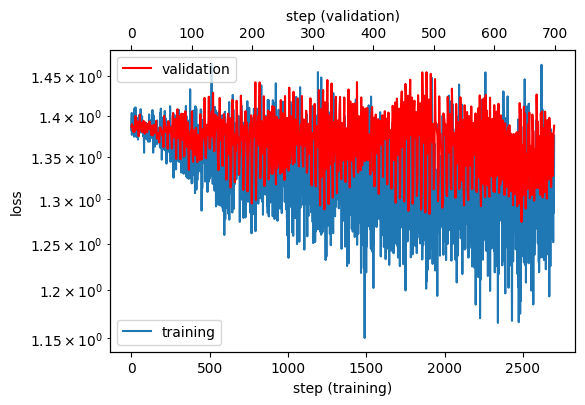

In [15]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

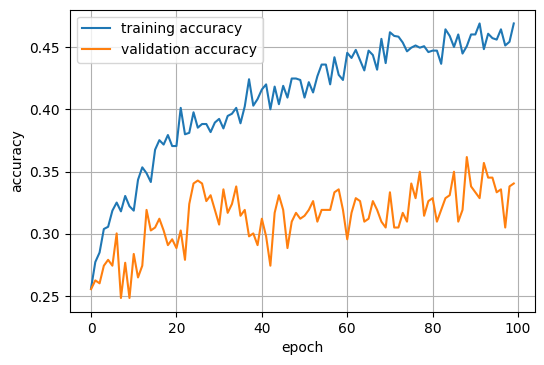

In [17]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()

###PURE GRU

In [18]:
class GRU_FC(nn.Module):
    def __init__(self, input_shape=(22, 1000), hidden_shape=128, n_classes=4, n_layers=3):
        super().__init__() # call __init__ method of superclass

        self.input_shape = input_shape

        self.gru = nn.Sequential(
            nn.GRU(1000, 64, n_layers, batch_first=True, dropout = 0.6),
        )

        self.dense = nn.Sequential(            
            nn.Linear(64, n_classes),
        )
        

        self.elu = nn.ELU()

        return

    def forward(self, x):
        h = x

        #h = h.view(self.input_shape[0], self.input_shape[1])
        #h = h.view(h.shape[0], -1)

        # print(x.size())

        # N, C, H, W = x.size()
        # x = x.view(N, H, W).permute(0, 2, 1)
        # h, _ = self.gru(x)

        h, _ = self.gru(h)

        h = self.elu(h)

        h = self.dense(h)

        return h

In [19]:
from torchinfo import summary

# Only uses outputs of modules.
print(summary(GRU_FC(), input_size=(22, 1000)))

Layer (type:depth-idx)                   Output Shape              Param #
GRU_FC                                   [22, 4]                   --
├─Sequential: 1-1                        [22, 64]                  --
│    └─GRU: 2-1                          [22, 64]                  254,592
├─ELU: 1-2                               [22, 64]                  --
├─Sequential: 1-3                        [22, 4]                   --
│    └─Linear: 2-2                       [22, 4]                   260
Total params: 254,852
Trainable params: 254,852
Non-trainable params: 0
Total mult-adds (M): 358.47
Input size (MB): 0.09
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.12


In [20]:
l2_reg = 1e-4

model = GRU_FC().to(device)
# For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
#   or implement it manually and add it to the loss before backward propagation.

# Declare an optimizer that handles weight updates
# This optimizer also has its own state dictionary
optimizer = torch.optim.Adam(model.parameters(), weight_decay=l2_reg, lr=1e-3)   
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [21]:
num_epochs = 50

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch

        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        out = torch.mean(out, 2) 
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step

        # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
        # Otherwise you will run out of memory.
        # You MUST use .item() to convert to a scalar or call .detach().
        loss_hist.append(loss.item())
    
    model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            out = torch.mean(out, 2) 
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            out = model(x)
            out = torch.mean(out, 2) 
            loss = celoss(out, y)
            val_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

100%|██████████████████████████████| 50/50 [00:15<00:00,  3.21it/s, acc=0.891, val_acc=0.277]


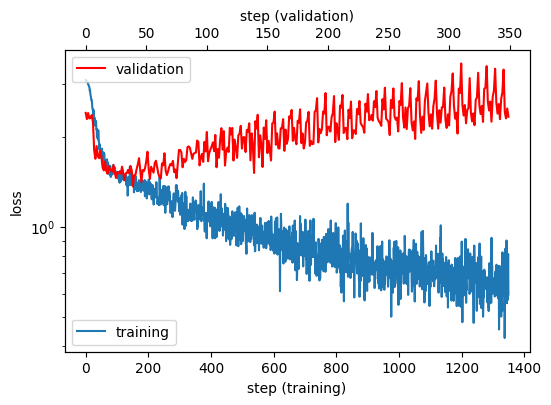

In [22]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

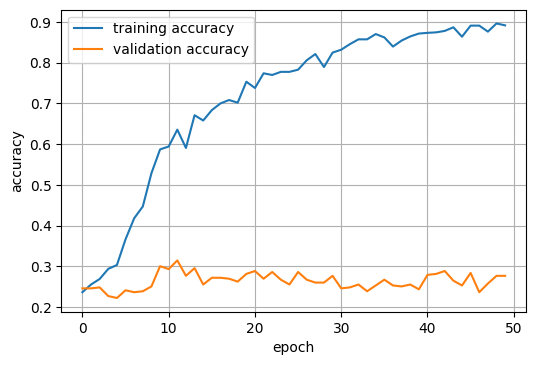

In [23]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()